In [1]:
import numpy as np
import pandas as pd
import torch
import os

In [2]:
from scipy.stats import wasserstein_distance
from itertools import combinations

# Calculate the wasserstein distance for each dataset

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import ot
import re

def plot_annotated_heatmap(df, cmap="coolwarm", fmt=".2f", figsize=(16, 16), cbar_shrink=0.5):
    """
    Plots a heatmap of a square DataFrame with annotated values after setting the diagonal to 0
    and normalizing the matrix so that the sum of all values equals 1.

    Parameters:
        df (pd.DataFrame): A square DataFrame to be plotted.
        cmap (str): Colormap for the heatmap.
        fmt (str): Format string for annotations.
        figsize (tuple): Size of the figure.
        cbar_shrink (float): Factor to shrink the color bar (default is 0.5).
    """
    if df.shape[0] != df.shape[1]:
        raise ValueError("The input DataFrame must be square (same number of rows and columns).")

    df = df.copy()  # Avoid modifying the original DataFrame

    # Set diagonal to 0
    np.fill_diagonal(df.values, 0)

    # Normalize so that the sum of all values is 1
    df /= df.sum().sum()

    plt.figure(figsize=figsize)
    sns.heatmap(df, annot=False, fmt=fmt, cmap=cmap, linewidths=0.5, square=True, cbar=True, 
                cbar_kws={"shrink": cbar_shrink})  # Adjust the color bar size
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.show()

def compute_wasserstein_matrix(df, x_col='x', y_col='y', cell_type_col='cell_type'):
    """
    Compute the Wasserstein-2 distance between each pair of cell types based on x, y positions.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with spatial coordinates and cell type annotations.
    x_col (str): Column name for x-coordinate.
    y_col (str): Column name for y-coordinate.
    cell_type_col (str): Column name for cell type annotation.
    
    Returns:
    pd.DataFrame: Symmetric matrix of Wasserstein distances between sanitized cell types.
    """
    # Group by cell type and extract coordinates
    cell_groups = {
        ctype: group[[x_col, y_col]].values 
        for ctype, group in df.groupby(cell_type_col)
    }
    
    # Get list of unique cell types and sanitize names
    cell_types = sorted(cell_groups.keys())
    sanitized_names = {ctype: re.sub(r'[^a-zA-Z0-9\/+&]', '_', ctype) if isinstance(ctype, str) else ctype for ctype in cell_types}
    
    # Initialize distance matrix
    distance_matrix = pd.DataFrame(np.zeros((len(cell_types), len(cell_types))), 
                                   index=[sanitized_names[ctype] for ctype in cell_types], 
                                   columns=[sanitized_names[ctype] for ctype in cell_types])

    # Compute Wasserstein distances
    for i, type_a in enumerate(cell_types):
        for j, type_b in enumerate(cell_types[i:], i):  # Avoid redundant computations
            if type_a == type_b:
                continue  # Skip self-comparison
            coords_a = cell_groups[type_a]
            coords_b = cell_groups[type_b]
            
            # Compute cost matrix (Euclidean distance)
            M = ot.dist(coords_a, coords_b, metric='euclidean')

            # Uniform weights
            a = np.ones(len(coords_a)) / len(coords_a)
            b = np.ones(len(coords_b)) / len(coords_b)

            # Compute Wasserstein-2 distance
            w_distance = np.sqrt(ot.emd2(a, b, M))

            # Store in symmetric matrix with sanitized names
            distance_matrix.at[sanitized_names[type_a], sanitized_names[type_b]] = w_distance
            distance_matrix.at[sanitized_names[type_b], sanitized_names[type_a]] = w_distance  # Symmetry

    plot_annotated_heatmap(distance_matrix)
    return distance_matrix

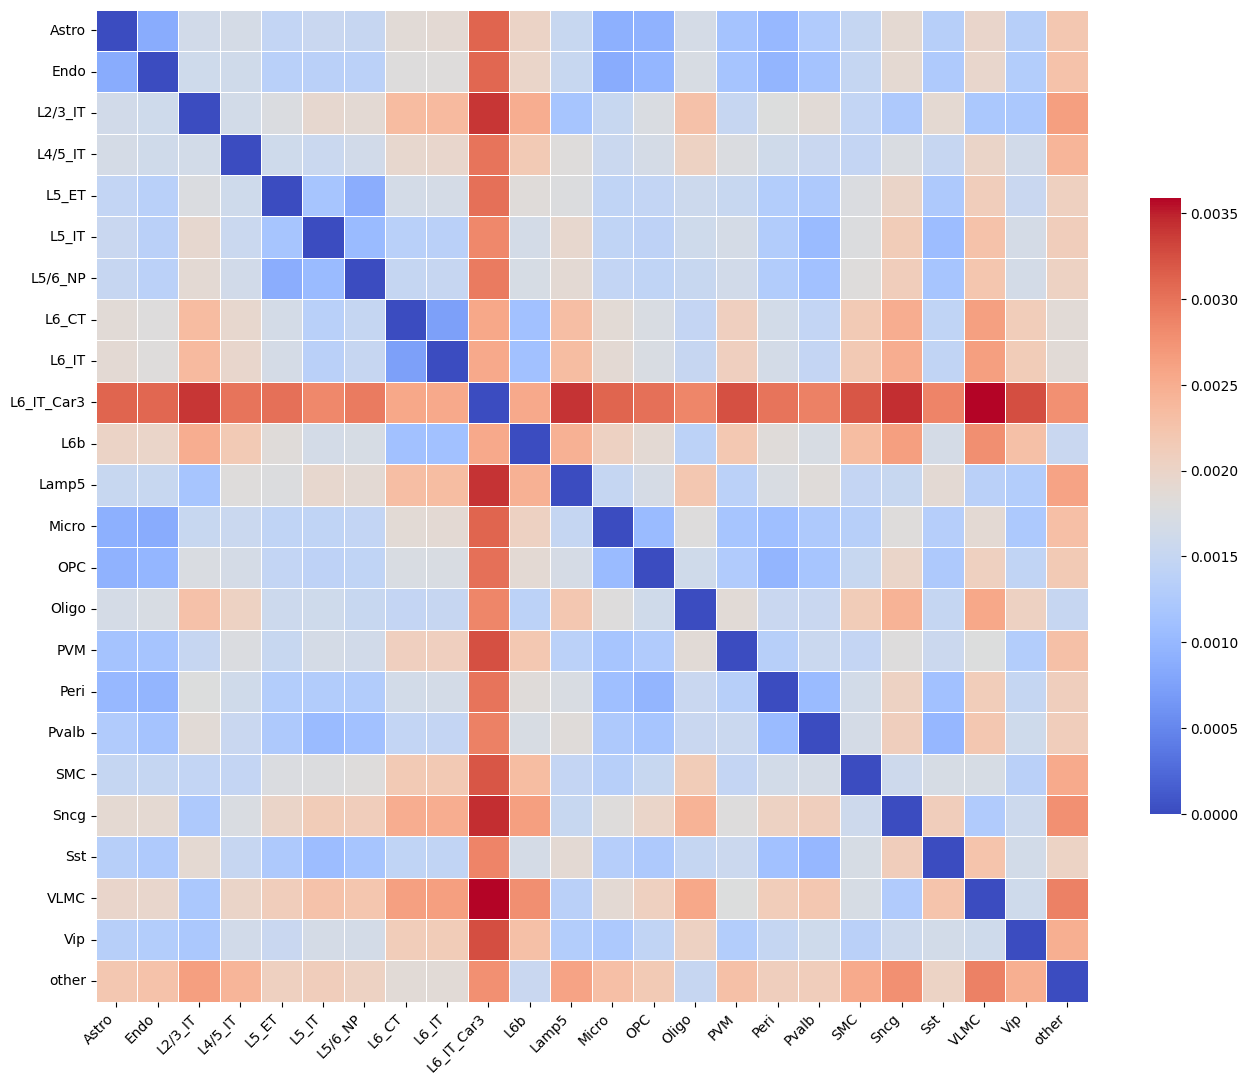

In [4]:
# Mouse brain
df=pd.read_csv("./data/mouse/mouse.csv")
df=df[df['slice_id']=="mouse1_slice201"].copy()
dist_matrix=compute_wasserstein_matrix(df, x_col='centerx', y_col='centery', cell_type_col='subclass')
cell_types_mouse=np.unique(df['subclass'].values)
dist_matrix.to_csv("./distance/mouse.csv")

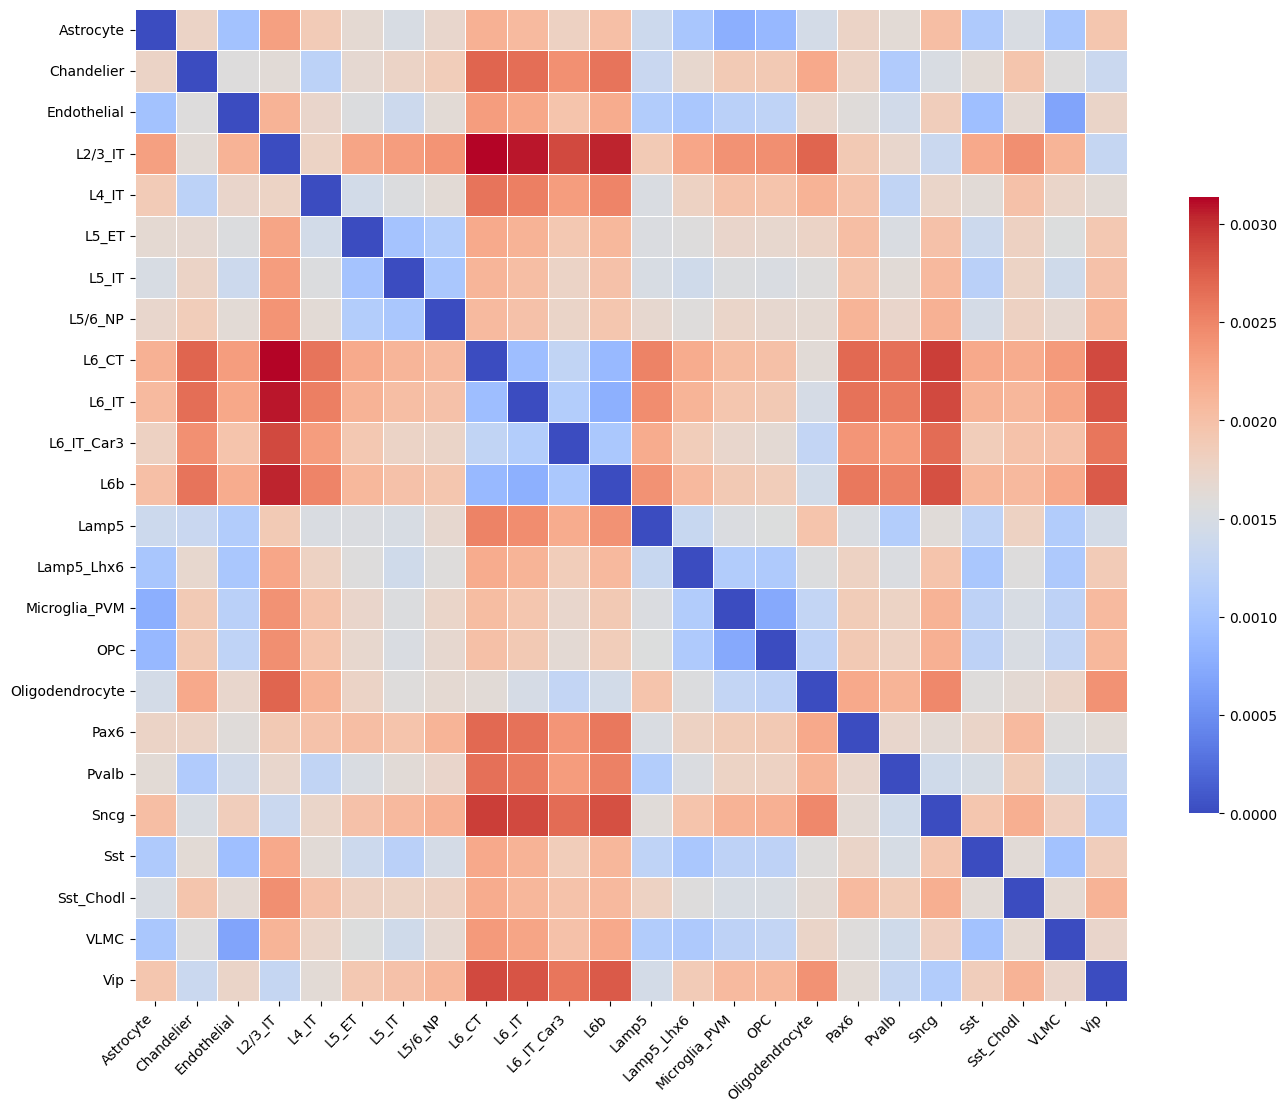

In [5]:
# AD
df=pd.read_csv("./data/AD/AD.csv")
df=df[df["section"]=="H20.33.001.CX28.MTG.02.007.1.02.03"].copy()
dist_matrix=compute_wasserstein_matrix(df, x_col='centerx', y_col='centery', cell_type_col='subclass')
cell_types_AD=np.unique(df['subclass'].values)
dist_matrix.to_csv("./distance/AD.csv")

/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


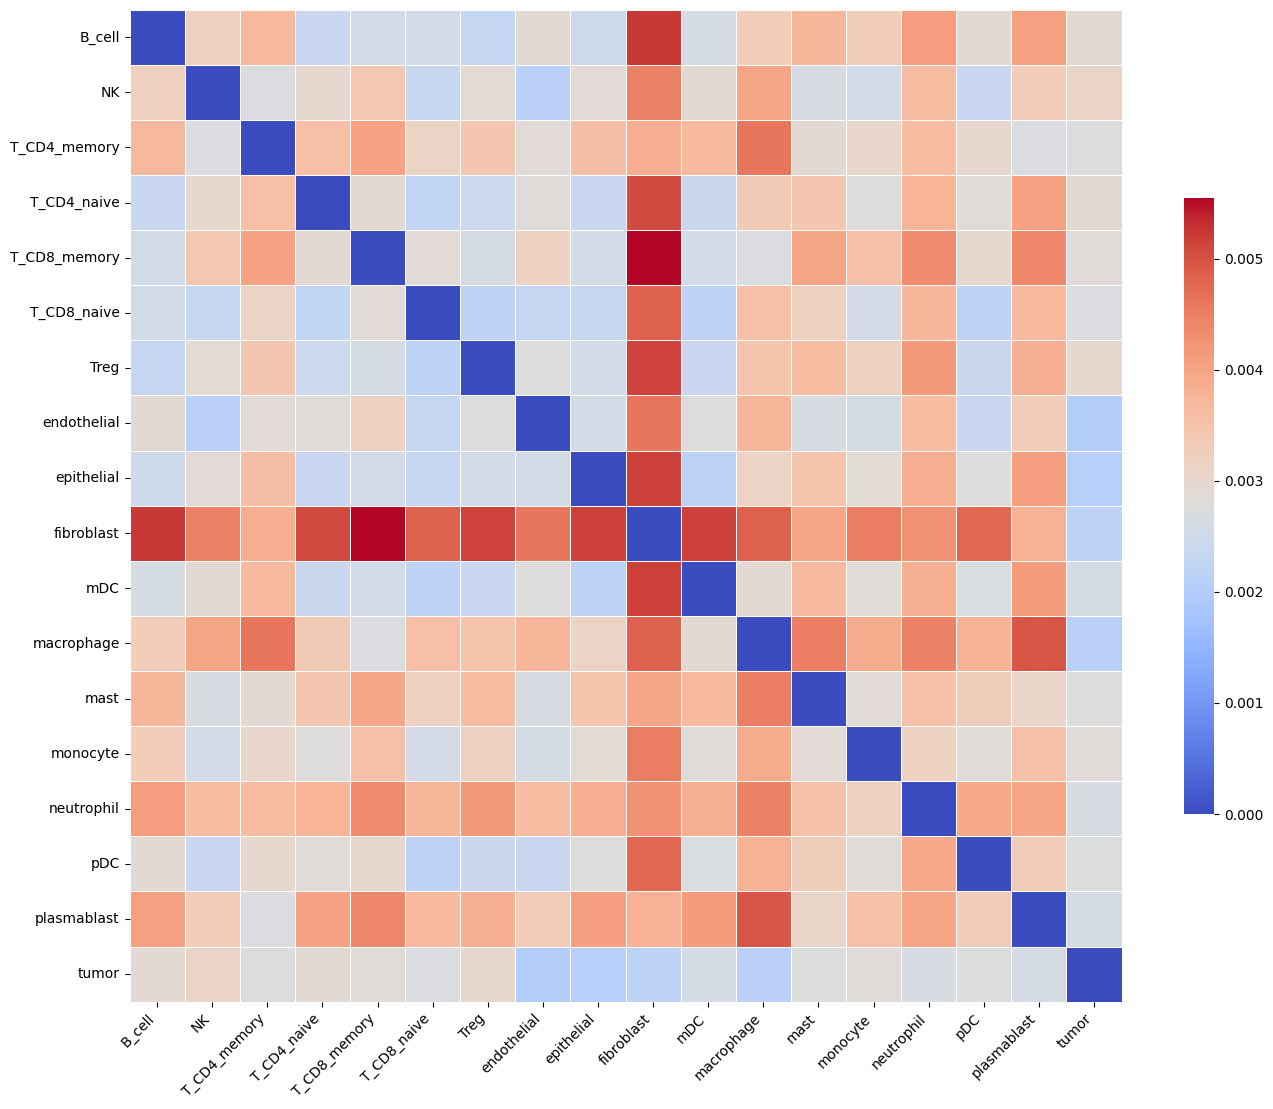

In [6]:
# NSCLC
df=pd.read_csv("./data/NSCLC/NSCLC.csv")
df=df[df["section"]=="Lung6"].copy()
dist_matrix=compute_wasserstein_matrix(df, x_col='CenterX_global_px', y_col='CenterY_global_px', cell_type_col='CellType')
cell_types_NSCLC=np.unique(df['CellType'].values)
dist_matrix.to_csv("./distance/NSCLC.csv")

/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


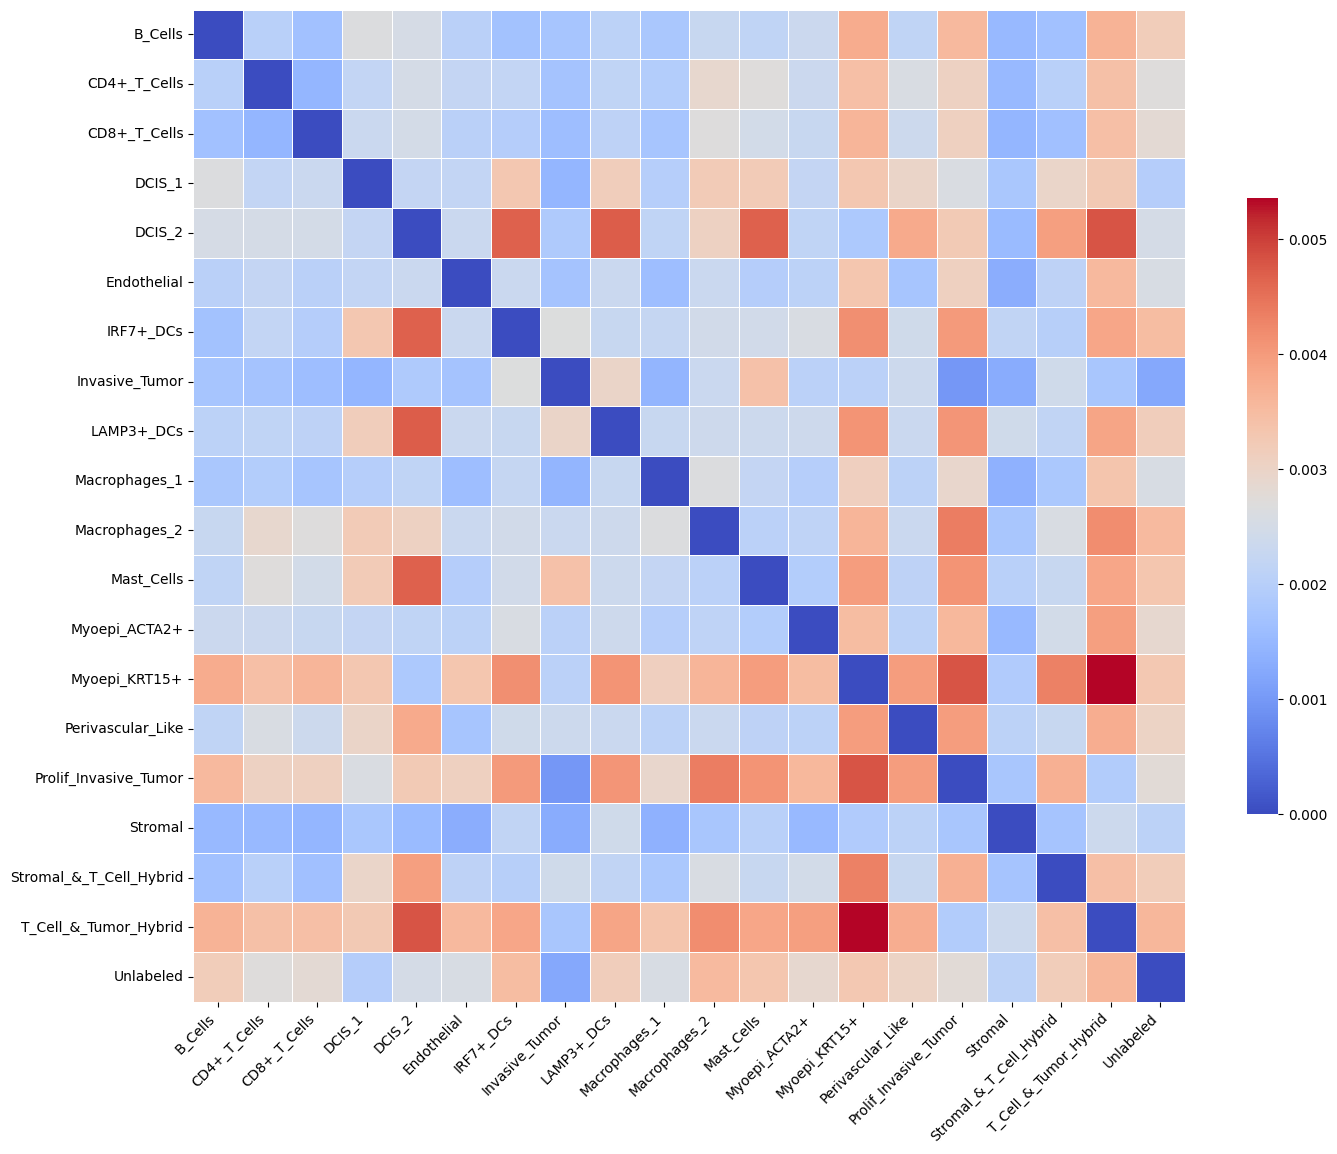

In [7]:
# BC
df=pd.read_csv("./data/BC/BC.csv")
df=df[df["section"]=="sample1_rep1"].copy()
dist_matrix=compute_wasserstein_matrix(df, x_col='centerx', y_col='centery', cell_type_col='subclass')
cell_types_BC=np.unique(df['subclass'].values)
dist_matrix.to_csv("./distance/BC.csv")

# Evaluate the NSCLC dataset

In [8]:
import re

def sanitize_string(s):
    return re.sub(r'[^a-zA-Z0-9\/+&]', '_', s) if isinstance(s, str) else s
    
def sanitize_dataframe(df):

    # Apply sanitization to column names
    df.columns = [sanitize_string(col) for col in df.columns]
    
    # Apply sanitization to row index names
    df.index = [sanitize_string(idx) for idx in df.index]
    
    # Apply sanitization to all string values in the DataFrame
    df = df.applymap(sanitize_string)
    
    return df

In [9]:
def clean_and_sort_dataframe(df):
    """
    Cleans and sorts the row and column names of a given DataFrame.

    - Replaces any character not in [a-zA-Z0-9/+&] with '_'.
    - Sorts both row and column names.

    Parameters:
    df (pd.DataFrame): Input DataFrame.

    Returns:
    pd.DataFrame: Cleaned and sorted DataFrame.
    """
    def clean_name(name):
        return re.sub(r'[^a-zA-Z0-9\/+&]', '_', name) if isinstance(name, str) else name

    # Clean index and columns
    df.index = df.index.map(clean_name)
    df.columns = df.columns.map(clean_name)

    # Sort index and columns
    df = df.sort_index(axis=0).sort_index(axis=1)

    return df

In [10]:
def build_communication_tensor(df, ligand_col, receptor_col, sender_col, receiver_col, strength_col, cell_types):
    """
    Constructs a 3D tensor representing cell type networks for each unique ligand-receptor pair.
    
    Parameters:
    df (pd.DataFrame): Dataframe containing ligand, receptor, sender cell type, receiver cell type, and communication strength.
    ligand_col (str): Column name for ligand.
    receptor_col (str): Column name for receptor.
    sender_col (str): Column name for sender cell type.
    receiver_col (str): Column name for receiver cell type.
    strength_col (str): Column name for communication strength.
    cell_types (list): List of all possible cell types.
    
    Returns:
    np.ndarray: 3D tensor of shape (num_cell_types, num_cell_types, num_ligand_receptor_pairs).
    list: List of unique ligand-receptor pairs in order.
    """
    cell_types=[sanitize_string(i) for i in cell_types]
    
    # Get unique ligand-receptor pairs
    df['ligand_receptor'] = df[ligand_col] + "_" + df[receptor_col]
    unique_pairs = df['ligand_receptor'].unique()
    
    # Sort cell types for consistent matrix ordering
    cell_types = sorted(cell_types)
    num_cell_types = len(cell_types)
    num_pairs = len(unique_pairs)
    
    # Create an index mapping for cell types
    cell_type_idx = {cell: i for i, cell in enumerate(cell_types)}
    
    # Initialize the 3D tensor
    tensor = np.zeros((num_cell_types, num_cell_types, num_pairs))
    
    # Fill the tensor
    for k, pair in enumerate(unique_pairs):
        subset = df[df['ligand_receptor'] == pair]
        for _, row in subset.iterrows():
            sender = row[sender_col]
            receiver = row[receiver_col]
            strength = row[strength_col]
            if sender in cell_type_idx and receiver in cell_type_idx:
                i, j = cell_type_idx[sender], cell_type_idx[receiver]
                tensor[i, j, k] = strength
            else:
                print("wrong",sender,receiver)
    
    return tensor, list(unique_pairs)

In [11]:
# Spatalk
df=pd.read_csv("./NSCLC_spatalk.csv")
df=sanitize_dataframe(df)
spatalk_all=build_communication_tensor(df=df, ligand_col="ligand", receptor_col="receptor", sender_col="celltype_sender", receiver_col="celltype_receiver", strength_col="score", cell_types=cell_types_NSCLC)

/tmp/ipykernel_1706902/636579942.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(sanitize_string)


(18, 18, 200)


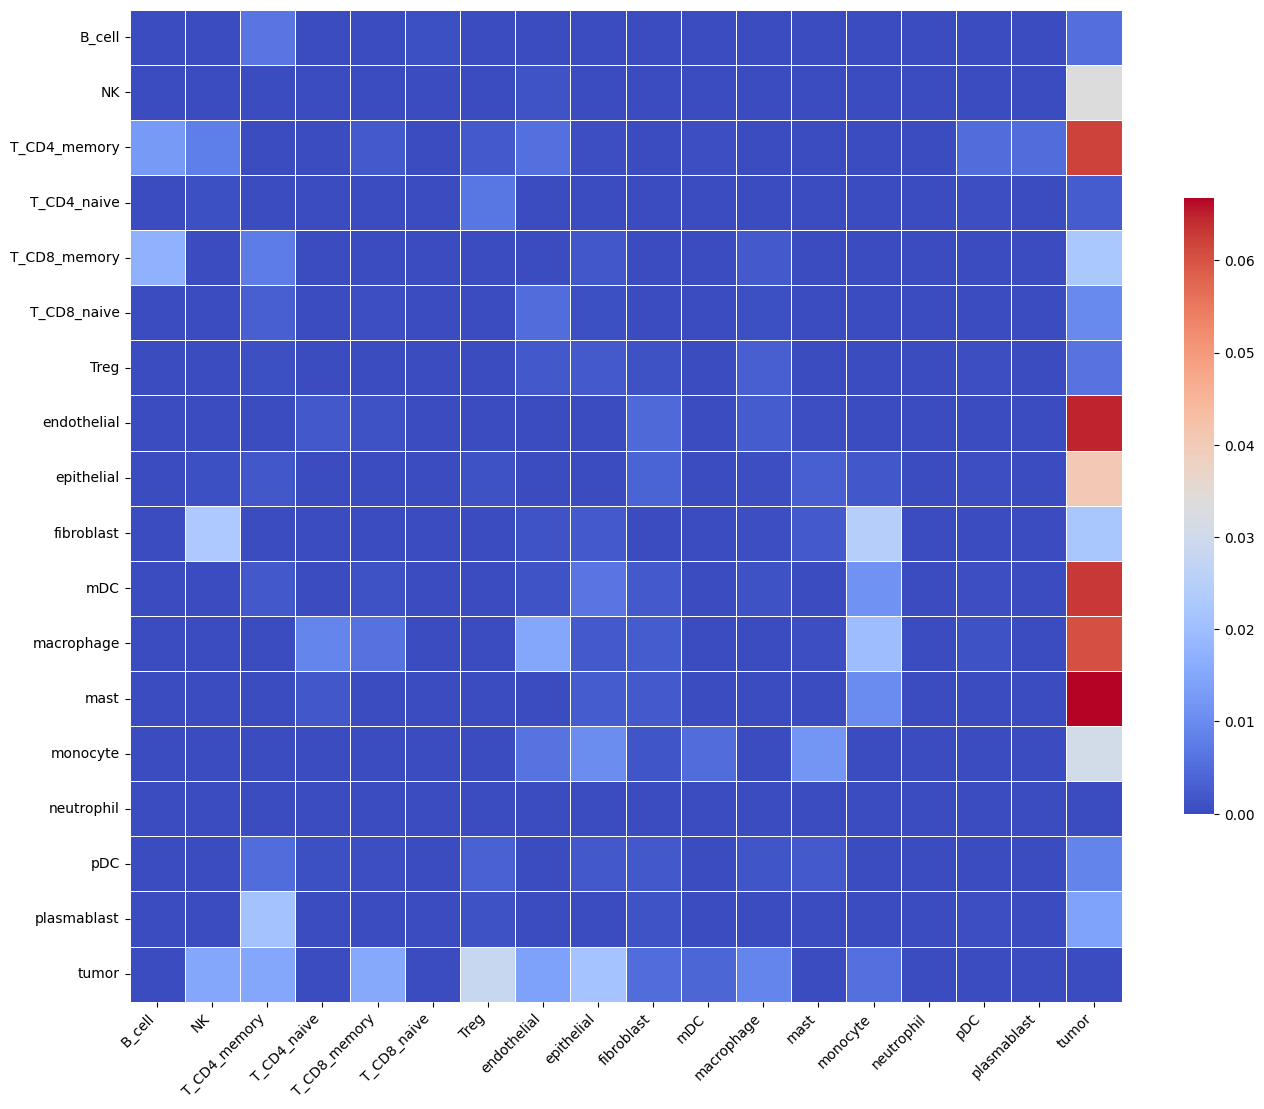

In [12]:
spatalk=spatalk_all[0]
print(spatalk.shape)
spatalk=spatalk/np.sum(spatalk,axis=(0,1),keepdims=True)
spatalk=np.mean(spatalk,axis=-1)
spatalk=pd.DataFrame(spatalk, columns=sorted(cell_types_NSCLC), index=sorted(cell_types_NSCLC))
spatalk=clean_and_sort_dataframe(spatalk)
plot_annotated_heatmap(spatalk)

/tmp/ipykernel_1706902/636579942.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(sanitize_string)


                B_cell        NK  T_CD4_memory  T_CD4_naive  T_CD8_memory  \
B_cell        0.000322  0.000011      0.000113     0.000009      0.000159   
NK            0.000121  0.000537      0.000112     0.000071      0.000165   
T_CD4_memory  0.000556  0.000808      0.003516     0.000681      0.001258   
T_CD4_naive   0.000207  0.000020      0.000133     0.000026      0.000174   
T_CD8_memory  0.000264  0.000184      0.000215     0.000143      0.000778   
T_CD8_naive   0.000241  0.000090      0.000282     0.000152      0.000323   
Treg          0.000123  0.000022      0.000096     0.000002      0.000118   
endothelial   0.001421  0.001136      0.002356     0.000757      0.002092   
epithelial    0.000594  0.000408      0.000568     0.000234      0.000856   
fibroblast    0.000911  0.001728      0.004159     0.001077      0.002160   
mDC           0.000151  0.000025      0.000173     0.000012      0.000264   
macrophage    0.000420  0.000502      0.000549     0.000443      0.001038   

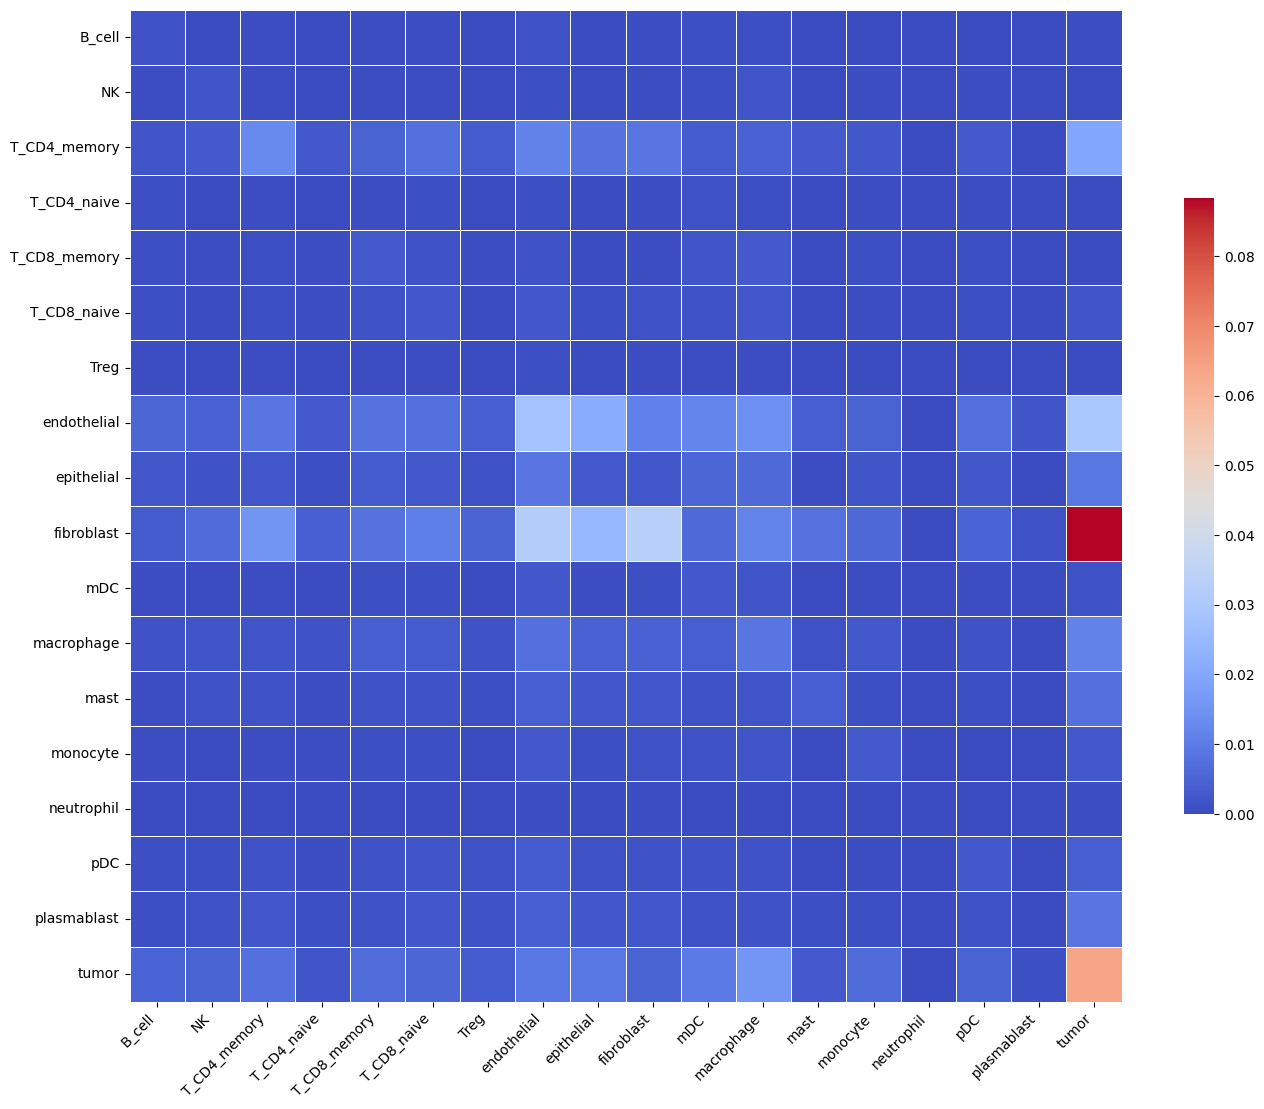

In [13]:
# cellchat
cellchat=pd.read_csv("./CellChat/NSCLC_aggregated.csv",index_col=0)
cellchat=sanitize_dataframe(cellchat)
cellchat=clean_and_sort_dataframe(cellchat)
print(cellchat)
plot_annotated_heatmap(cellchat)

In [14]:
# CellPhoneDB
cellphone_all=torch.load("./CellphoneDB/NSCLC.pth",weights_only=False)

In [37]:
import pandas as pd
import re

def process_cellphone(df, cell_types):
    # Step 1: Filter columns containing "|"
    filtered_cols = [col for col in df.columns if "|" in col]
    
    if not filtered_cols:
        raise ValueError("No columns found containing '|' in the name.")
    
    # Step 2: Compute row sums for selected columns
    row_sums = df[filtered_cols].sum(axis=1)
    
    # Step 3: Remove rows where the sum is 0
    df_filtered = df[row_sums > 0].copy()

    # Step 4: Normalize remaining rows
    normalized_df = df_filtered[filtered_cols]
    
    # Step 5: Compute the mean across rows for selected columns
    mean_values = normalized_df.mean()
    
    # Step 6: Prepare a square dataframe with sorted cell types
    cell_types = sorted(set(cell_types))  # Ensure unique, sorted cell types
    agg_df = pd.DataFrame(0, index=cell_types, columns=cell_types, dtype=float)

    # Step 7: Aggregate values into a square matrix
    for col, value in mean_values.items():
        parts = col.split("|")
        if len(parts) == 2:
            cell_type_A, cell_type_B = parts
            if cell_type_A in cell_types and cell_type_B in cell_types:
                agg_df.loc[cell_type_A, cell_type_B] += value

    # Step 8: Apply regex-based name formatting
    formatted_index = [re.sub(r'[^a-zA-Z0-9\/+&]', '_', str(idx)) for idx in agg_df.index]
    formatted_columns = [re.sub(r'[^a-zA-Z0-9\/+&]', '_', str(col)) for col in agg_df.columns]
    
    agg_df.index = formatted_index
    agg_df.columns = formatted_columns

    return agg_df


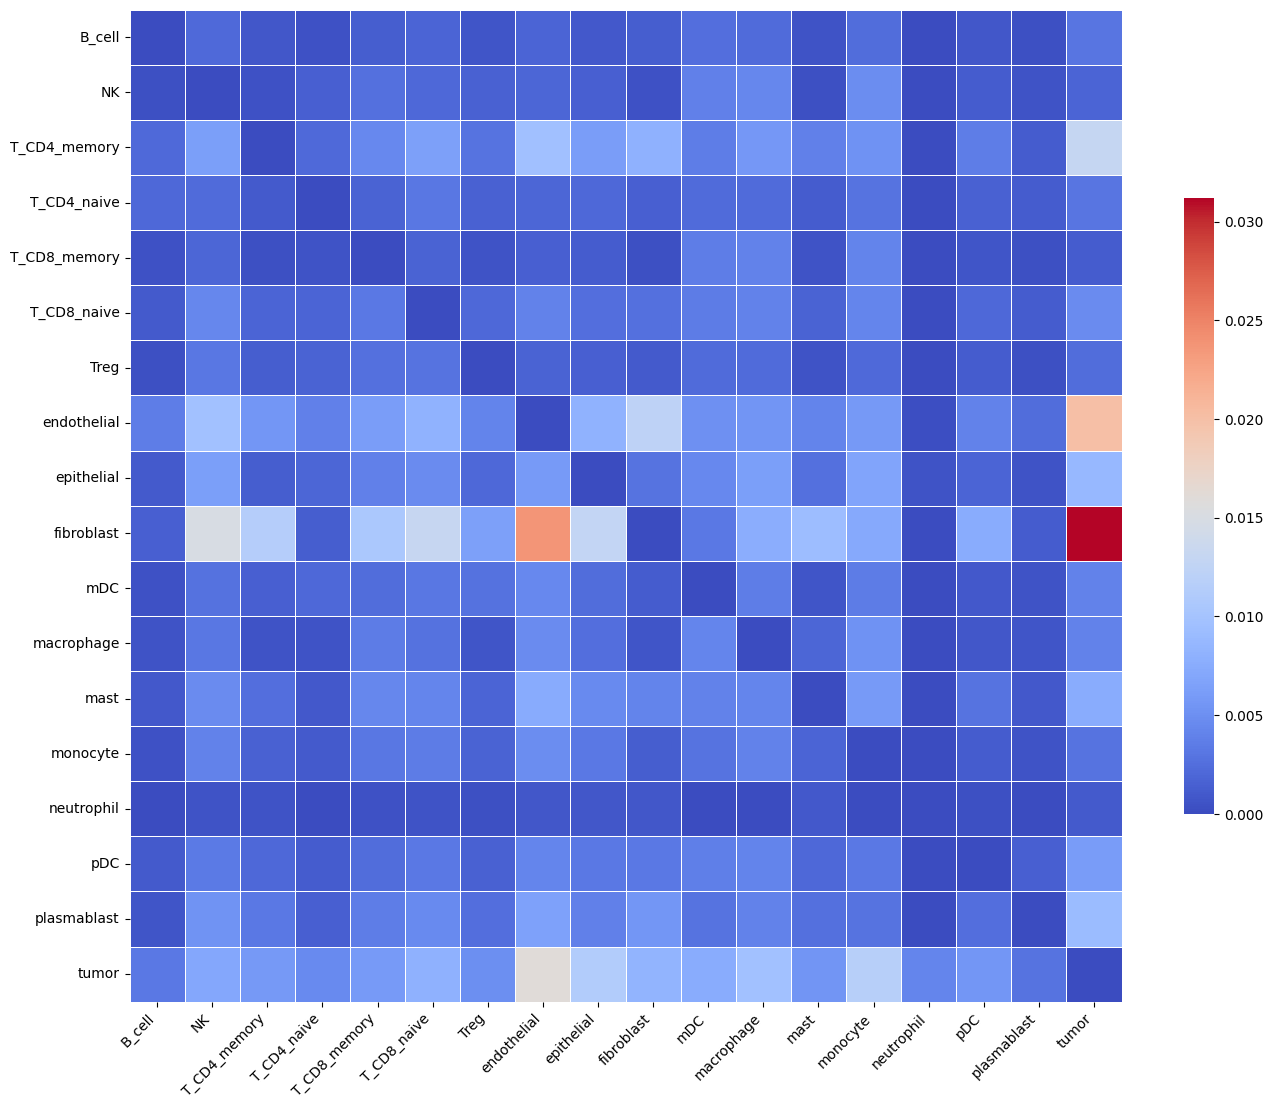

In [38]:
cellphone=process_cellphone(cellphone_all['interaction_scores'],cell_types_NSCLC)
cellphone=clean_and_sort_dataframe(cellphone)
plot_annotated_heatmap(cellphone)

In [17]:
# GITIII
results=torch.load("/vast/palmer/scratch/wang_zuoheng/xx244/GITIII_backup/NSCLC_evaluate/edges/"+"edges_"+"Lung6"+".pth",map_location=torch.device('cpu'))

In [34]:
attention_scores=results["attention_score"]/8
attention_scores=torch.abs(attention_scores)
attention_scores=attention_scores/torch.sum(attention_scores,dim=(0,1),keepdim=True)
attention_scores=torch.mean(attention_scores,dim=-1)
#attention_scores=attention_scores/torch.sum(attention_scores,dim=-1,keepdim=True)
print(attention_scores.shape,attention_scores)

torch.Size([89091, 49]) tensor([[1.6198e-06, 1.2169e-06, 4.7957e-07,  ..., 1.0265e-07, 5.8994e-08,
         7.8496e-08],
        [2.6525e-06, 6.3357e-07, 2.5617e-07,  ..., 1.3824e-07, 5.3094e-08,
         9.4552e-08],
        [3.0320e-06, 1.5755e-06, 5.6262e-07,  ..., 7.3587e-08, 5.2325e-08,
         5.6888e-08],
        ...,
        [1.8167e-06, 5.8376e-07, 3.1634e-07,  ..., 3.1839e-07, 6.6032e-08,
         2.6326e-07],
        [2.4924e-06, 2.5105e-06, 1.1893e-06,  ..., 6.1160e-08, 6.5681e-08,
         1.2626e-07],
        [2.3296e-06, 1.0330e-06, 5.3198e-07,  ..., 1.2070e-07, 2.3255e-07,
         5.7919e-08]])


In [35]:
cell_type_matrix=np.array(results['cell_type_name'])
print(cell_type_matrix.shape)

(89091, 50)


/tmp/ipykernel_1706902/212396081.py:38: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  normalized_df = normalized_df.groupby(normalized_df.columns, axis=1).sum()


                    B_cell            NK  T_CD4_memory   T_CD4_naive  \
B_cell        2.155459e-08  1.877879e-09  4.359063e-09  9.537099e-09   
NK            1.037415e-09  3.008666e-09  1.183789e-09  1.239940e-09   
T_CD4_memory  5.834072e-09  4.685325e-09  6.783830e-09  7.066637e-09   
T_CD4_naive   1.139969e-08  2.892156e-09  5.862245e-09  1.221130e-08   
T_CD8_memory  7.045568e-09  4.677776e-09  3.737795e-09  4.733895e-09   
T_CD8_naive   1.292756e-08  7.097782e-09  8.999622e-09  1.194721e-08   
Treg          6.736159e-09  3.198155e-09  3.182620e-09  5.581991e-09   
endothelial   1.351191e-08  1.210004e-08  1.730007e-08  1.317770e-08   
epithelial    2.416624e-08  1.792715e-08  2.048142e-08  1.881746e-08   
fibroblast    1.154593e-08  1.393538e-08  2.832096e-08  1.156064e-08   
mDC           6.807798e-09  4.367970e-09  6.203267e-09  6.913800e-09   
macrophage    1.852088e-08  2.666839e-08  1.694544e-08  2.017747e-08   
mast          1.449909e-09  8.958781e-10  1.425956e-09  1.553524

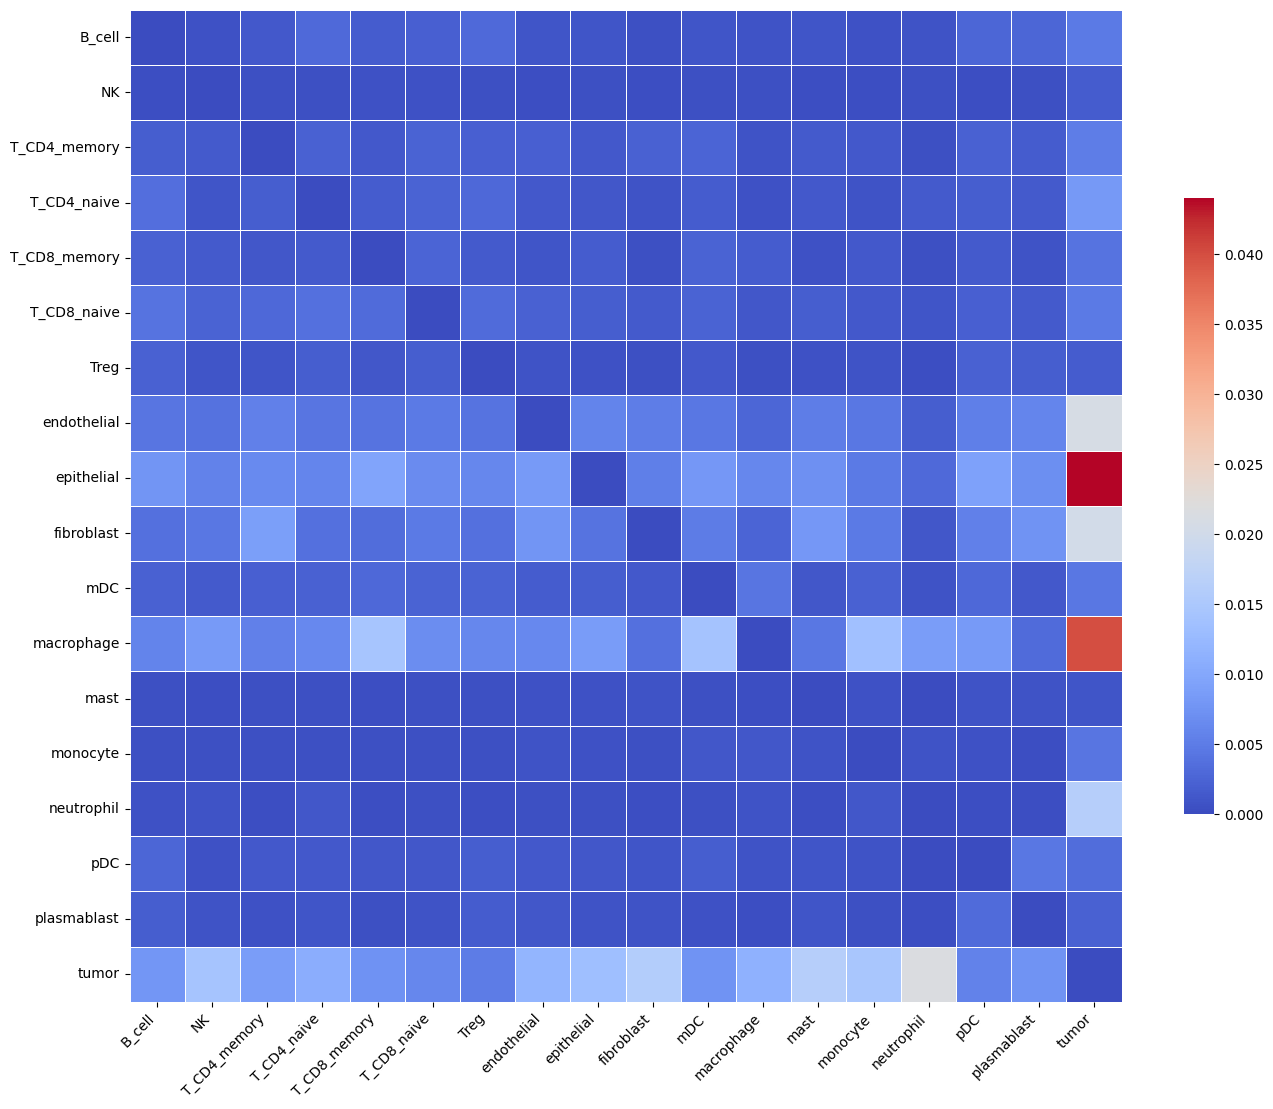

In [44]:
def rename_cell_type(cell_type):
    """Rename cell types containing 'tumor' to 'tumor' and sanitize others."""
    if "tumor" in cell_type.lower():
        return "tumor"
    return re.sub(r'[^a-zA-Z0-9\/+&]', '_', cell_type)

def aggregate_attention_scores(attention_scores, cell_type_matrix):
    """Compute the sum of attention scores for each sender-receiver cell type pair 
    and normalize by the number of receiver cells of each type, ensuring float values."""
    
    # Extract receiver and sender cell types
    receiver_types = cell_type_matrix[:, 0]  # First column: receiver cell type
    sender_types = cell_type_matrix[:, 1:]  # Other columns: sender cell type

    # Flatten data to count interactions
    data = []
    for i in range(attention_scores.shape[0]):
        for j in range(attention_scores.shape[1]):
            data.append((receiver_types[i], sender_types[i, j], float(attention_scores[i, j])))

    df = pd.DataFrame(data, columns=["Receiver", "Sender", "Score"])

    # Compute sum of attention scores for each sender-receiver pair
    sum_scores = df.groupby(["Sender", "Receiver"])["Score"].sum().unstack(fill_value=0)

    # Count the number of receiver cells per receiver type
    receiver_counts = df.groupby("Receiver").size()

    # Normalize by the number of receiver cells per receiver type
    normalized_df = sum_scores.div(receiver_counts, axis=1).fillna(0)

    # Rename cell types
    normalized_df.index = [rename_cell_type(idx) for idx in normalized_df.index]
    normalized_df.columns = [rename_cell_type(col) for col in normalized_df.columns]

    # Aggregate after renaming
    normalized_df = normalized_df.groupby(normalized_df.index).sum()
    normalized_df = normalized_df.groupby(normalized_df.columns, axis=1).sum()
    
    # Sort the dataframe
    sorted_index = sorted(normalized_df.index)
    sorted_columns = sorted(normalized_df.columns)
    normalized_df = normalized_df.loc[sorted_index, sorted_columns]

    # Convert all values to float explicitly
    normalized_df = normalized_df.astype(float)

    return normalized_df

GITIII=aggregate_attention_scores(attention_scores, cell_type_matrix)
print(GITIII)
plot_annotated_heatmap(GITIII)

In [45]:
summary={"GITIII":GITIII,"SpaTalk":spatalk,"CellphoneDB":cellphone, "CellChat":cellchat}

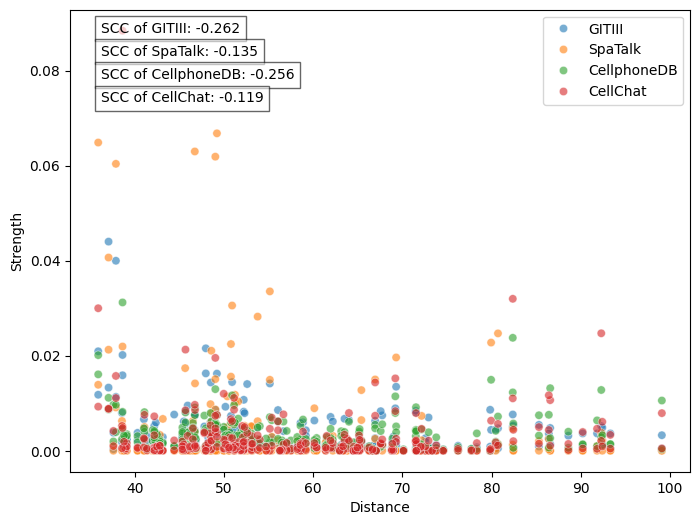

In [46]:
import scipy.stats as stats
#import ace_tools as tools

def normalize_dataframe(df):
    """
    Normalize a square dataframe by setting diagonal values to 0 
    and then scaling all values so that their sum equals 1.
    """
    df = df.copy()
    np.fill_diagonal(df.values, 0)  # Set diagonal to 0
    total_sum = df.values.sum()
    if total_sum > 0:
        df /= total_sum  # Normalize to sum to 1
    return df

def extract_and_plot_df_no_diag_scc(data_dict, distance_df):
    """
    Extract non-diagonal elements from normalized squared data dataframes 
    and a single distance dataframe, plot data values against distances 
    with colors representing matrix names, and annotate the Spearman correlation 
    coefficient for each matrix, excluding diagonal values from SCC calculation.

    Parameters:
    - data_dict: dict, keys are matrix names and values are square pandas DataFrames (data values)
    - distance_df: pandas DataFrame, a single square matrix representing distances
    """
    plot_data = []

    if any(mat.shape != distance_df.shape for mat in data_dict.values()):
        raise ValueError("All data dataframes must have the same shape as the distance dataframe")

    if distance_df.shape[0] != distance_df.shape[1]:
        raise ValueError("Distance dataframe is not square")

    # Extract non-diagonal elements
    mask = ~np.eye(distance_df.shape[0], dtype=bool)
    distances = distance_df.values[mask]

    for name, data_df in data_dict.items():
        norm_df = normalize_dataframe(data_df)  # Normalize the data dataframe
        values = norm_df.values[mask]

        # Compute Spearman correlation excluding diagonal values
        spearman_corr, _ = stats.spearmanr(values, distances)

        for v, d in zip(values, distances):
            plot_data.append([name, v, d, spearman_corr])

    # Convert to dataframe
    df = pd.DataFrame(plot_data, columns=["Name", "Value", "Distance", "SpearmanCorr"])

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x="Distance", y="Value", hue="Name", alpha=0.6)

    # Annotate correlation
    for name in df["Name"].unique():
        subset = df[df["Name"] == name]
        spearman_corr, _ = stats.spearmanr(subset["Value"], subset["Distance"])  # Recalculate without diagonal
        plt.text(0.05, 0.95 - list(df["Name"].unique()).index(name) * 0.05, f"SCC of {name}: {spearman_corr:.3f}",
                 transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

    plt.xlabel("Distance")
    plt.ylabel("Strength")
    plt.legend()
    plt.show()


extract_and_plot_df_no_diag_scc(summary, pd.read_csv("./distance/NSCLC.csv",index_col=0))

In [25]:
mask = ~np.eye(18, dtype=bool)

stats.pearsonr(pd.read_csv("./distance/NSCLC.csv",index_col=0).values[mask].flatten(),GITIII.values[mask].flatten())

PearsonRResult(statistic=-0.22395391829594524, pvalue=7.754259497166412e-05)

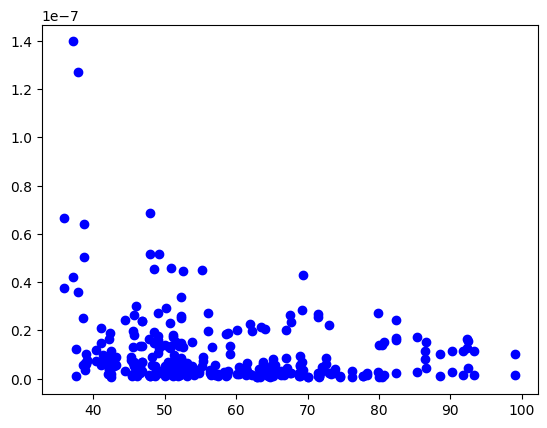

In [26]:
plt.scatter(pd.read_csv("./distance/NSCLC.csv",index_col=0).values[mask].flatten(),GITIII.values[mask].flatten(), color='blue', marker='o')